In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from custom_transformers import *
from augmentation_generator_batch_size import *

C:\Users\basiu\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# One-hot
Y_train = to_categorical(Y_train.flatten())
Y_test = to_categorical(Y_test.flatten())

k = Y_train.shape[1]

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000, 10) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000, 10)


## CNN Random Square Cutout without soft labeling

### max_size_ratio = 0.1, max_number_of_squares = 25

In [4]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.1, max_number_of_squares = 25)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor = square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [5]:
k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


C:\Users\basiu\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 219s 95ms/step - accuracy: 0.8132 - loss: 0.5652 - val_accuracy: 0.8708 - val_loss: 0.3339
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 199s 89ms/step - accuracy: 0.9004 - loss: 0.2701 - val_accuracy: 0.8985 - val_loss: 0.2737
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 192s 85ms/step - accuracy: 0.9192 - loss: 0.2232 - val_accuracy: 0.9149 - val_loss: 0.2409
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 193s 86ms/step - accuracy: 0.9295 - loss: 0.1915 - val_accuracy: 0.9205 - val_loss: 0.2240
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 258s 114ms/step - accuracy: 0.9386 - loss: 0.1688 - val_accuracy: 0.9213 - val_loss: 0.2265
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 238s 106ms/step - accuracy: 0.9470 - loss: 0.1430 - val_accuracy: 0.9200 - val_loss: 0.2345


In [7]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1000
           1       1.00      0.99      0.99      1000
           2       0.91      0.86      0.88      1000
           3       0.94      0.92      0.93      1000
           4       0.88      0.88      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.70      0.85      0.76      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



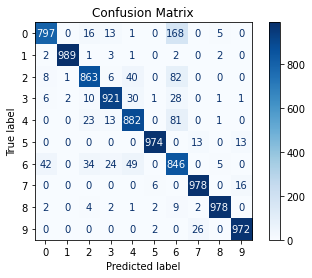

In [8]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9451
Final Validation Accuracy: 0.9200


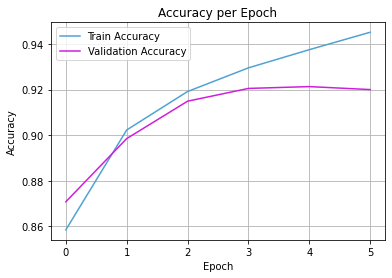

In [9]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

### max_size_ratio = 0.1, max_number_of_squares = 10

In [10]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.1, max_number_of_squares = 10)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)


In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


C:\Users\basiu\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 226s 98ms/step - accuracy: 0.8127 - loss: 0.5915 - val_accuracy: 0.8884 - val_loss: 0.3000
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 228s 101ms/step - accuracy: 0.9021 - loss: 0.2672 - val_accuracy: 0.9020 - val_loss: 0.2666
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 263s 117ms/step - accuracy: 0.9202 - loss: 0.2148 - val_accuracy: 0.9043 - val_loss: 0.2626
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 226s 100ms/step - accuracy: 0.9291 - loss: 0.1931 - val_accuracy: 0.9142 - val_loss: 0.2292
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 227s 101ms/step - accuracy: 0.9420 - loss: 0.1571 - val_accuracy: 0.9285 - val_loss: 0.1998
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 223s 99ms/step - accuracy: 0.9482 - loss: 0.1419 - val_accuracy: 0.9269 - val_loss: 0.2196


In [12]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.94      0.87      0.90      1000
           3       0.93      0.94      0.93      1000
           4       0.83      0.94      0.88      1000
           5       0.99      0.99      0.99      1000
           6       0.77      0.78      0.77      1000
           7       0.98      0.96      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



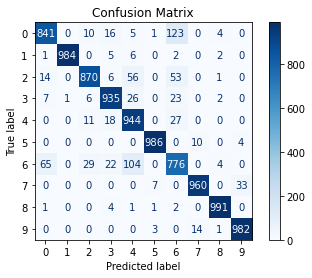

In [13]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9476
Final Validation Accuracy: 0.9269


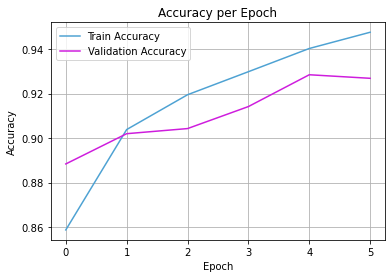

In [14]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

### max_size_ratio = 0.05, max_number_of_squares = 10

In [15]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.05, max_number_of_squares = 10)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)


In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


C:\Users\basiu\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 225s 98ms/step - accuracy: 0.8164 - loss: 0.5677 - val_accuracy: 0.8965 - val_loss: 0.2857
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 221s 98ms/step - accuracy: 0.9001 - loss: 0.2841 - val_accuracy: 0.8807 - val_loss: 0.3656
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 207s 92ms/step - accuracy: 0.8921 - loss: 0.3844 - val_accuracy: 0.8670 - val_loss: 0.4507
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 205s 91ms/step - accuracy: 0.8687 - loss: 0.9247 - val_accuracy: 0.8630 - val_loss: 0.8611
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 200s 89ms/step - accuracy: 0.8541 - loss: 2.4318 - val_accuracy: 0.8265 - val_loss: 4.1828
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 222s 99ms/step - accuracy: 0.8121 - loss: 10.1031 - val_accuracy: 0.7253 - val_loss: 17.4550


In [17]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1000
           1       0.99      0.91      0.95      1000
           2       0.42      0.86      0.56      1000
           3       0.76      0.82      0.79      1000
           4       0.69      0.42      0.52      1000
           5       0.78      0.98      0.87      1000
           6       0.49      0.17      0.26      1000
           7       0.77      0.89      0.82      1000
           8       0.98      0.87      0.92      1000
           9       0.97      0.58      0.73      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.71     10000
weighted avg       0.75      0.73      0.71     10000



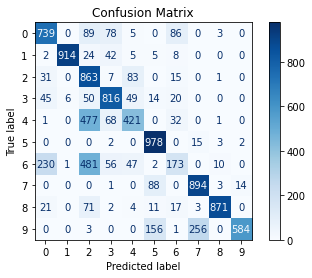

In [18]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.8099
Final Validation Accuracy: 0.7253


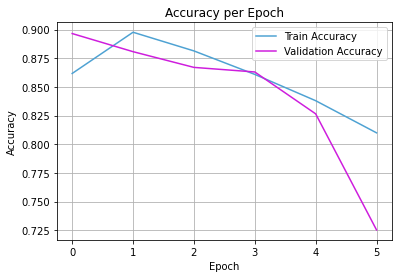

In [19]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()